In [0]:
#Priya Rajpurohit 2015073
#Sakshi Saini 2017092

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.layers.core import Layer
import keras.backend as K

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 

from keras import backend as K 
from keras.utils import np_utils
import os
import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from zipfile import ZipFile


Using TensorFlow backend.


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive1 = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=10fFInHmGZ5PsbMTRb_7EuhJcGNHisjCi'
fluff, id = link.split('=')

10fFInHmGZ5PsbMTRb_7EuhJcGNHisjCi


In [0]:
downloaded = drive1.CreateFile({'id':id}) 
downloaded.GetContentFile('Segmented.zip')

with ZipFile('/content/Segmented.zip', 'r') as zipObj:
   zipObj.extractall()


In [0]:
path = '/content/Segmented/'
images=[]
lable = 1
labels = []
for r, d, f in os.walk(path):
    for folder in d:
        
        for r1, d1, f1 in os.walk(os.path.join(r, folder)):
          for file in f1:
            # print(file)
            image = cv2.imread(os.path.join(r1, file) )
            image = cv2.resize(image, (224, 224))
            images.append(image)
            labels.append(lable)

          lable = lable +1
images = np.array(images)


(48153, 256, 256, 3)

In [0]:
X_train, X_test, y_train, y_test = train_test_split( images[:20000], labels[:20000], test_size=0.3, random_state=42 , shuffle=True)
print(X_train.shape, X_test.shape)

In [0]:
np.unique(y_train).shape
n = 38

y_train = np_utils.to_categorical( y_train, n)
y_test = np_utils.to_categorical( y_test, n)

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
   

In [0]:
# Code is being refered form the link mentioned below
# https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output
    

In [0]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)


In [0]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(38, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(38, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(38, activation='softmax', name='output')(x)


In [0]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')


In [0]:
model.summary()


Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [0]:
epochs = 25
initial_lrate = 0.005

def decay(epoch, steps=100):
    initial_lrate = 0.005
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=True)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [0]:
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), epochs=epochs, batch_size=24, callbacks=[lr_sc])


Train on 14000 samples, validate on 6000 samples
Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.005.
14000/14000 [==============================] - 411s 29ms/step - loss: 3.0183 - output_loss: 1.8916 - auxilliary_output_1_loss: 1.8448 - auxilliary_output_2_loss: 1.9086 - output_accuracy: 0.3380 - auxilliary_output_1_accuracy: 0.3754 - auxilliary_output_2_accuracy: 0.3498 - val_loss: 2.3130 - val_output_loss: 1.6185 - val_auxilliary_output_1_loss: 1.0624 - val_auxilliary_output_2_loss: 1.2526 - val_output_accuracy: 0.4257 - val_auxilliary_output_1_accuracy: 0.6258 - val_auxilliary_output_2_accuracy: 0.5452
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.005.
14000/14000 [==============================] - 404s 29ms/step - loss: 1.4355 - output_loss: 0.9233 - auxilliary_output_1_loss: 0.8366 - auxilliary_output_2_loss: 0.8687 - output_accuracy: 0.6899 - auxilliary_output_1_accuracy: 0.7255 - auxilliary_output_2_accuracy: 0.7146 - val_lo

In [0]:
final_accuracy = history.history["val_output_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

FINAL ACCURACY MEAN-5:  0.9585333347320557


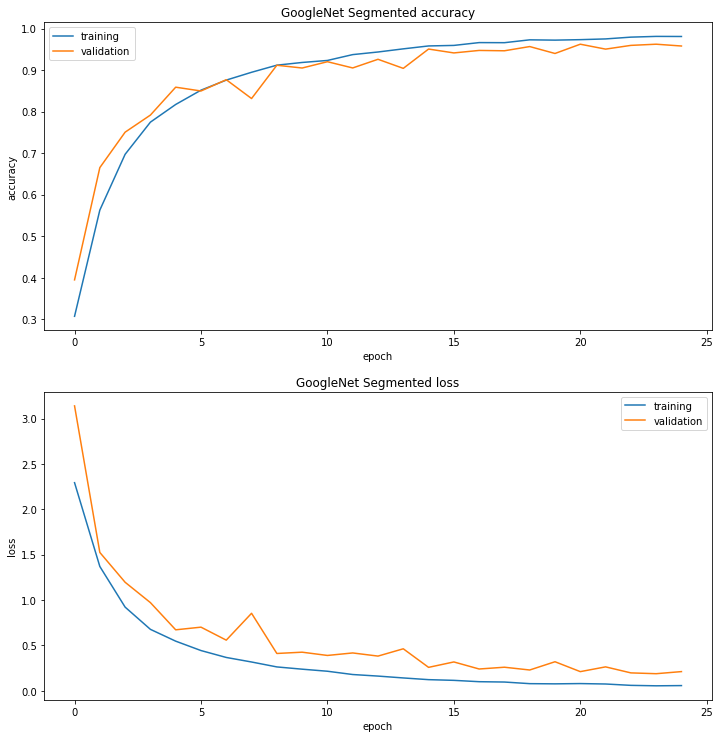

In [0]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('GoogleNet Segmented '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['output_accuracy'], history.history['val_output_accuracy'], 'accuracy', 211)
display_training_curves(history.history['output_loss'], history.history['val_loss'], 'loss', 212)


In [0]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

In [0]:
history.history

{'auxilliary_output_1_accuracy': [0.31464285,
  0.60635716,
  0.7139286,
  0.7673572,
  0.80864286,
  0.83421427,
  0.85728574,
  0.87357146,
  0.8891429,
  0.90164286,
  0.9072143,
  0.91735715,
  0.9243571,
  0.9349286,
  0.9392857,
  0.945,
  0.9452143,
  0.9499286,
  0.95521426,
  0.95757145,
  0.9562143,
  0.96107143,
  0.9662857,
  0.9672857,
  0.9670714],
 'auxilliary_output_1_loss': [2.305858,
  1.2733238,
  0.89256567,
  0.7083732,
  0.59483165,
  0.49632776,
  0.42810923,
  0.37771544,
  0.32408047,
  0.2998351,
  0.2663013,
  0.23511817,
  0.21998926,
  0.19520098,
  0.17853911,
  0.16410643,
  0.15629394,
  0.14534819,
  0.12819697,
  0.12229902,
  0.12650883,
  0.11078954,
  0.103324704,
  0.09194297,
  0.09407147],
 'auxilliary_output_2_accuracy': [0.30157143,
  0.59114283,
  0.7054286,
  0.76464283,
  0.8017857,
  0.8339286,
  0.85885715,
  0.8757143,
  0.89107144,
  0.9005714,
  0.90842855,
  0.9210714,
  0.92728573,
  0.9326429,
  0.9415714,
  0.9448571,
  0.9492143,
 

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")


In [0]:
with open('file.json', 'w') as f:
    json.dump(history.history, f)
    